## **Getting the Dataset**

Seismic datasets are usually computationally represented as 3D scalar fields, being each voxel of the volume a 32-bits floating-point (amplitude). The Society of Exploration Geophysics (SEG) made available an [online repository](https://wiki.seg.org/wiki/Open_data) with major surveys from onshore and offshore areas.

For this tutorial, we will use two marine seismic blocks from the Netherlands and New Zealand offshore regions.

The first dataset is the [F3-Netherlands](https://wiki.seg.org/wiki/F3_Netherlands): a 1 GByte time migrated 3D seismic cube. It is available through the Creative Commons 3.0 license. Check the [dGB repository](https://terranubis.com/datainfo/F3-Demo-2020) for a complete reference.

The dataset was modified to adjust the header such that it could be read by the [segyio](https://github.com/equinor/segyio) library:


In [8]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D" -O F3.sgy && rm -rf /tmp/cookies.txt

--2021-05-08 19:57:09--  https://docs.google.com/uc?export=download&confirm=mxTc&id=1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D
Resolving docs.google.com (docs.google.com)... 142.250.128.138, 142.250.128.101, 142.250.128.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.128.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-5o-docs.googleusercontent.com/docs/securesc/r9qr2qi7a2eeirj7n2ca07u7ctml6mk6/qabj0mi4rndj31tpk329hcv2ar4qbf95/1620503775000/17311170770924402329/16830488108076082694Z/1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D?e=download [following]
--2021-05-08 19:57:09--  https://doc-0k-5o-docs.googleusercontent.com/docs/securesc/r9qr2qi7a2eeirj7n2ca07u7ctml6mk6/qabj0mi4rndj31tpk329hcv2ar4qbf95/1620503775000/17311170770924402329/16830488108076082694Z/1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D?e=download
Resolving doc-0k-5o-docs.googleusercontent.com (doc-0k-5o-docs.googleusercontent.com)... 142.250.125.132, 2607:f8b0:4001:c2f::84
Conne

## **Download Extra Libraries**

To process GLCM attributes, this code requires some extra libraries and modules such as **OpenCV**. If you download [scikit-image](https://scikit-image.org/) modules, it should be enough to compute other attributes based on image features.

In [9]:
!pip install segyio opencv-python numpy > /dev/null 2>&1

## **Reading Seismic Cubes**

Firstly, we will explore the impact of RAPIDS for seismic facies classification on the F3 seismic block.

Pre- and post-stack seismic cubes are often stored following the [SEG-Y standard](https://en.wikipedia.org/wiki/SEG-Y). Notice that most of the files available in SEG Open data repository are released as .sgy files.

Equinor made available an easy-to-use SEG-Y file reader with a Python interface. The [segyio](https://github.com/equinor/segyio) is a small LGPL licensed C library for easy interaction with SEG-Y and Seismic Unix formatted seismic data, with language bindings for both Python and Matlab.

Let's make a preliminary check on the seismic cubes using the **segyio** library and verify that number of inlines, crosslines, and time slices match the reference we have on SEG repository:


In [10]:
import os
import segyio

import numpy as np

input_file = 'F3.sgy'

def inspect_seismic_cubes(file_name):
    segy_file = segyio.open(file_name)

    iline_start = int(segy_file.ilines[0])
    iline_end = int(segy_file.ilines[-1])
    iline_offset = int(segy_file.ilines[1] - segy_file.ilines[0])

    xline_start = int(segy_file.xlines[0])
    xline_end = int(segy_file.xlines[-1])
    xline_offset = int(segy_file.xlines[1] - segy_file.xlines[0])

    time_start = int(segy_file.samples[0])
    time_end = int(segy_file.samples[-1])
    time_offset = int(segy_file.samples[1] - segy_file.samples[0])
        
    print("File: {} \n"
          "Inline range: [{}, {}]. Offset: {}\n"
          "Crossline range: [{}, {}]. Offset: {}\n"
          "Time range: [{}, {}]. Offset: {}".format(os.path.basename(file_name),
                                                       iline_start, iline_end, iline_offset, 
                                                       xline_start, xline_end, xline_offset, 
                                                       time_start, time_end, time_offset))
    metadata = {
        'inline': (iline_start, iline_end, iline_offset),
        'crossline': (xline_start, xline_end, xline_offset),
        'time': (time_start, time_end, time_offset)
    }
    
    return metadata

metadata = inspect_seismic_cubes(input_file)
original_cube = np.array(segyio.tools.cube(input_file))
original_cube = np.ascontiguousarray(original_cube, 'float32')

print("Original cube dimension:", original_cube.shape)

File: F3.sgy 
Inline range: [100, 750]. Offset: 1
Crossline range: [300, 1250]. Offset: 1
Time range: [4, 1848]. Offset: 4
Original cube dimension: (651, 951, 462)


In [23]:
# We perform slicing to get a central region on the dataset
# to increase training quality and ensure it will fit GPU memory.
def get_sub_cube(cube, examples_percent):
    assert examples_percent > 0 and examples_percent <= 1.0, "Percent must be in (0,1] range."

    i_num, x_num, t_num = cube.shape

    i_start_idx = int((i_num - (i_num * examples_percent))/2)
    i_end_idx   = int(i_start_idx + (examples_percent * i_num))

    x_start_idx = int((x_num - (x_num * examples_percent))/2)
    x_end_idx   = int(x_start_idx + (examples_percent * x_num))

    t_start_idx = int((t_num - (t_num * examples_percent))/2)
    t_end_idx   = int(t_start_idx + (examples_percent * t_num))

    return cube[i_start_idx:i_end_idx,
                x_start_idx:x_end_idx,
                t_start_idx:t_end_idx]

# Change the following variable if you want to work with bigger or smaller cube fractions.
# The interval for @examples_percent is (0,1]. Defining examples_percent = 0.9
# will pick a central crop on the cube corresponding to 90% of available samples.
examples_percent = 0.9
cube = get_sub_cube(original_cube, examples_percent)

print("Sub-cube dimension:", cube.shape)

Sub-cube dimension: (585, 855, 415)


## **GLCM Attributes Computation**

For a better comprehension of what GLCM stands for Gray Level Co-occurrence Matrix. For further details of how to compute each feature of an original image see the original paper called ["GLCM Texture: a Tutorial"](https://prism.ucalgary.ca/handle/1880/51900)



In [44]:
import cv2

# GLCM Attributes Calculation
def fast_glcm(img, vmin, vmax, nbit, kernel_size):
    ks = kernel_size
    h,w = img.shape

    if not vmin:
        mi = np.amin(img)
    else:
        mi = vmin

    if not vmax:
        ma = np.amax(img)
    else:
        ma = vmax

    # digitize
    bins = np.linspace(mi, ma+1, nbit+1)
    gl1 = np.digitize(img, bins) - 1
    gl2 = np.append(gl1[:,1:], gl1[:,-1:], axis=1)

    # make glcm
    glcm = np.zeros((nbit, nbit, h, w), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm

def fast_glcm_homogeneity(img, vmin=None, vmax=None, nbit=32, kernel_size=3):
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, kernel_size)
    homo = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            homo += glcm[i,j] / (1.+(i-j)**2)

    return homo

def fast_glcm_mean(img, vmin=None, vmax=None, nbit=32, kernel_size=3):
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, kernel_size)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    return mean

def fast_glcm_std(img, vmin=None, vmax=None, nbit=32, kernel_size=3):
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, kernel_size)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    std2 = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            std2 += (glcm[i,j] * i - mean)**2

    std = np.sqrt(std2)
    return std

def fast_glcm_dissimilarity(img, vmin=None, vmax=None, nbit=32, kernel_size=3):
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, kernel_size)
    diss = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            diss += glcm[i,j] * np.abs(i-j)

    return diss

def fast_glcm_contrast(img, vmin=None, vmax=None, nbit=32, kernel_size=3):
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, kernel_size)
    cont = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            cont += glcm[i,j] * (i-j)**2

    return cont

def fast_glcm_asm(img, vmin=None, vmax=None, nbit=32, kernel_size=3):
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, kernel_size)
    asm = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            asm  += glcm[i,j]**2

    ene = np.sqrt(asm)
    return asm, ene

def fast_glcm_variance(img, vmin=None, vmax=None, nbit=32, kernel_size=3):
    summation = 0
    glcm = fast_glcm(img, vmin, vmax, nbit, kernel_size)
    mean = fast_glcm_mean(img, vmin, vmax, nbit, kernel_size)
    h, w = img.shape
    v=np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            v+= glcm[i, j] * i *(i-mean)
    return v

def fast_glcm_correlation(img, vmin=None, vmax=None, nbit=32, kernel_size=3):
    glcm = fast_glcm(img, vmin, vmax, nbit, kernel_size)
    Auto_correlation = np.zeros((glcm.shape[2], glcm.shape[3]), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            Auto_correlation += glcm[i, j] * i * j

    return Auto_correlation

## **Visualizing Seismic Section**

For sanity check, let's plot the inline at position 100 (`inline_index=100`). Therefore, we define an auxiliary `plot_slice` procedure, that will also be used thereafter.

Notice that axes are swapped for visualization purposes. Seismic sections are usually visualized using Z axes as depth/time dimension, and X or Y axes being inline or crossline.

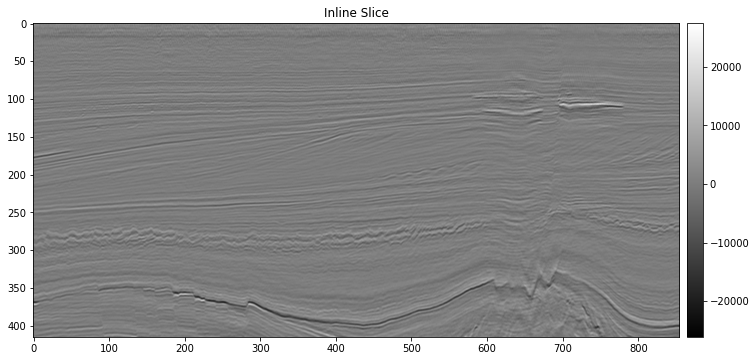

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

def plot_slice(slice, ax=None, title=None, cmap='gray', img_scale=0.015, interpolation='bicubic', is_discrete=False):
    img_h = int(slice.shape[0] * img_scale)
    img_w = int(slice.shape[1] * img_scale)    

    if not ax:
        plt.figure(figsize=(img_w, img_h))
        if title: plt.title(title)
        ax = plt.gca()
    else:
        if title: ax.set_title(title)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.1)
    
    if is_discrete:
        cmap = plt.get_cmap(cmap, np.max(slice)-np.min(slice)+1)
        im = ax.imshow(slice, cmap=cmap, interpolation=None, vmin = np.min(slice)-.5, vmax = np.max(slice)+.5)
        plt.colorbar(im, cax=cax, ticks=np.arange(np.min(slice),np.max(slice)+1))
    else:        
        im = ax.imshow(slice, cmap=cmap, interpolation=interpolation)
        plt.colorbar(im, cax=cax);
        
inline_index = 0
plot_slice(np.swapaxes(cube[inline_index,:,:], 0, 1), title='Inline Slice')

Now let's plot the GLCM attributes of this specific inline facie...

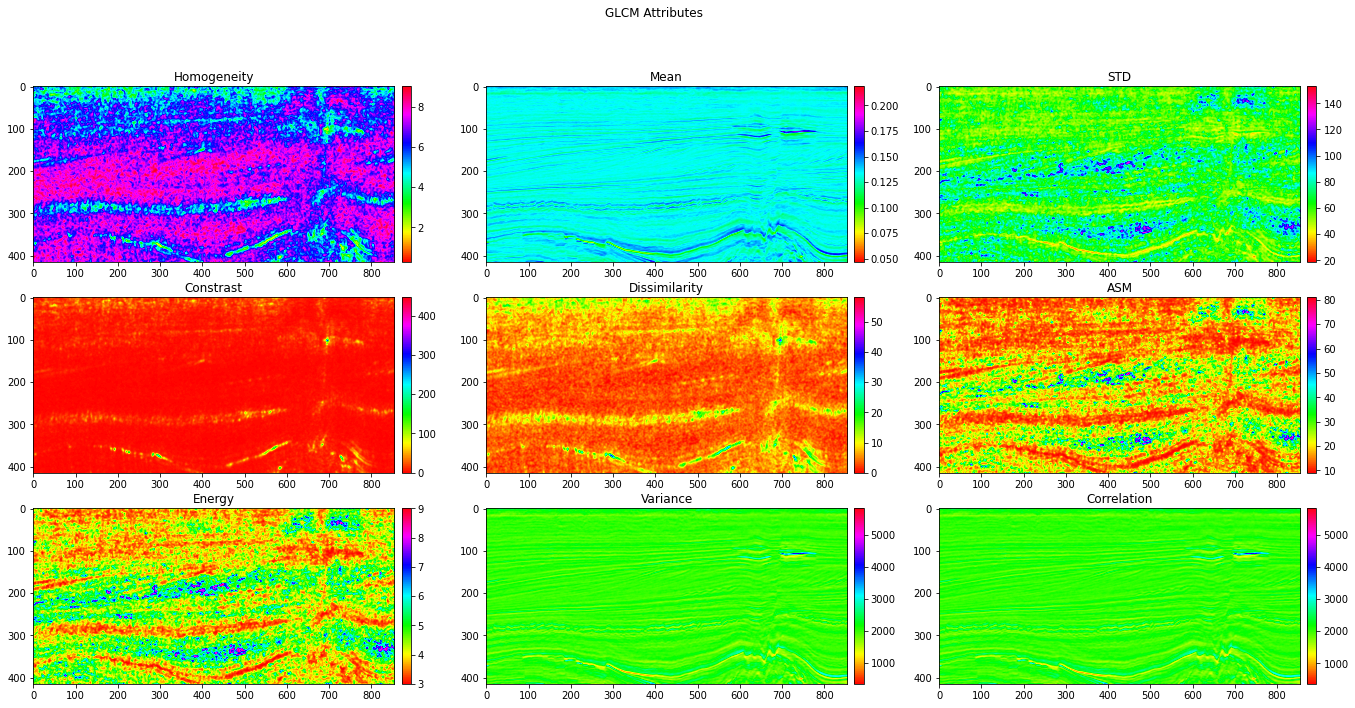

In [47]:
facie = np.swapaxes(cube[inline_index,:,:], 0, 1)
cmap = 'hsv'

homo = fast_glcm_homogeneity(facie)
mean = fast_glcm_mean(facie)
std = fast_glcm_std(facie)
contrast = fast_glcm_contrast(facie)
diss = fast_glcm_dissimilarity(facie)
asm, energy = fast_glcm_asm(facie)
var = fast_glcm_variance(facie)
cor = fast_glcm_correlation(facie)

img_h = int(facie.shape[0] * 0.0275)
img_w = int(facie.shape[1] * 0.0275)

fig, ax = plt.subplots(3, 3, figsize=(img_w, img_h))
fig.suptitle('GLCM Attributes')

plot_slice(homo, ax[0, 0], title='Homogeneity', cmap=cmap)
plot_slice(mean, ax[0, 1], title='Mean', cmap=cmap)
plot_slice(std, ax[0, 2], title='STD', cmap=cmap)
plot_slice(contrast, ax[1, 0], title='Constrast', cmap=cmap)
plot_slice(diss, ax[1, 1], title='Dissimilarity', cmap=cmap)
plot_slice(asm, ax[1, 2], title='ASM', cmap=cmap)
plot_slice(energy, ax[2, 0], title='Energy', cmap=cmap)
plot_slice(var, ax[2, 1], title='Variance', cmap=cmap)
plot_slice(cor, ax[2, 2], title='Correlation', cmap=cmap)